Date: 09.04.2023 \
Author: Reto Hendry

This script is to visualize the results of the parameter sweep.

## libraries and functions

In [79]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import statsmodels.api as sm
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression

sns.set_theme(style="ticks", palette="pastel")

# often used variables
tool_list = ["tpot", "pycaret", "h2o"]

In [80]:
# function to plot errorbars
def plot_errorbars(x, y, yerr, color, **kwargs):
    plt.errorbar(x, y, yerr=yerr, capsize=2, fmt='none', color=color, **kwargs)

In [81]:
def create_plot(col_var, x_var, x_label, datasets,
                progression_lines=False,):
    """
    Create a plot with the given variables.

    Parameters
    ----------
    col_var : str
        The variable to use for the different subplots.
    x_var : str
        The variable to use for the x-axis.
    x_label : str
        The label for the x-axis.
    progression_lines : bool, optional
        Whether to plot a regression line for the 
        training and test data, by default False.
    datasets : list, optional
        The datasets to use, i.e. [df_tpot, df_pycaret, df_h2o].

    Returns
    -------
    None (plots the figure)
    """

    
    for data in datasets:
        sns.set(style="whitegrid")
        g = sns.FacetGrid(data, col=col_var, height=2.5, aspect=1, col_wrap=4)

        # Training data
        g.map_dataframe(sns.scatterplot, x=x_var, y="CV_Accuracy_(Training)",
                        s=50, color='blue', label="CV_Accuracy_(Training)", alpha=0.5)
        g.map_dataframe(plot_errorbars, x=x_var, y="CV_Accuracy_(Training)",
                        yerr="CV_Std_(Training)", color='blue', label="CV_SD_(Training)", alpha=0.5)
        
        if progression_lines:
            g.map_dataframe(sns.regplot, x=x_var, y="CV_Accuracy_(Training)",
                            scatter=False, color='blue', label="CV_Accuracy_(Training)\nreg. line",
                            line_kws={"lw": 1, "ls": "--"})

        # Test data
        g.map_dataframe(sns.scatterplot, x=x_var, y="Accuracy_(Test)",
                        s=50, color='green', label="Accuracy_(Test)", marker="x", linewidth=1.5)
        if progression_lines:
            g.map_dataframe(sns.regplot, x=x_var, y="Accuracy_(Test)",
                            scatter=False, color='green', label="Accuracy_(Test)\nreg. line",
                            line_kws={"lw": 1, "ls": "--"})

        # Format the plot
        g.set_axis_labels(x_label, "Accuracy")
        g.set(ylim=(0, 1))
        g.add_legend()

        plt.show()

## check for duplicates with same parameters

In [95]:
for tool in tool_list:
    try:
        # analysis only for pycaret
        df_dup_check = pd.read_csv(f"../results/results_check_rep_{tool}.csv")
        df_dup_check["tool"] = tool

        # Remove duplicates ignoring the "id" field
        subset = list(df_dup_check.columns)
        subset.remove("id")
        df_no_dup = df_dup_check.drop_duplicates(subset=subset, keep="first")

        subset = ["component", "resample_cube", "number_of_features", "tool"]
        df_no_param_dup = df_dup_check.drop_duplicates(subset=subset, keep="first")

        print(f"tool: {tool}",
            f"shape of df before dropping duplicates: {df_dup_check.shape}",
            f"shape of df after dropping duplicates: {df_no_dup.shape}",
            f"shape of df after dropping parameter duplicates: {df_no_param_dup.shape}",
            sep="\n")

        no_dup_diff = len(df_no_dup) - len(df_no_param_dup)
        print(f"there are {no_dup_diff} models with the same parameters but different results \n")
    except:
        print(f"!! {tool} not found")
        pass

tool: tpot
shape of df before dropping duplicates: (180, 10)
shape of df after dropping duplicates: (99, 10)
shape of df after dropping parameter duplicates: (90, 10)
there are 9 models with the same parameters but different results 

tool: pycaret
shape of df before dropping duplicates: (180, 10)
shape of df after dropping duplicates: (90, 10)
shape of df after dropping parameter duplicates: (90, 10)
there are 0 models with the same parameters but different results 

tool: h2o
shape of df before dropping duplicates: (176, 10)
shape of df after dropping duplicates: (92, 10)
shape of df after dropping parameter duplicates: (88, 10)
there are 4 models with the same parameters but different results 



## Load results, concatenate, drop duplicates

In [83]:
# create a big dataframe with all the results from all autoML tools
tool_path_list = ["results_param_sweep_tpot.csv", "results_param_sweep_pycaret.csv", "results_param_sweep_h2o.csv"]

df = pd.DataFrame()

for tool in tool_path_list:
    df_i = pd.read_csv(f"../results/{tool}")
    df_i["tool"] = tool.split("_")[-1].split(".")[0]
    df = pd.concat([df_i, df])

In [84]:
# Remove duplicates ignoring the "id" field
subset = list(df.columns)
subset.remove("id")
df_no_dup = df.drop_duplicates(subset=subset, keep="first")

subset = ["component", "resample_cube", "number_of_features", "tool"]
df_no_param_dup = df.drop_duplicates(subset=subset, keep="first")

print(f"shape of df before dropping duplicates: {df.shape}",
      f"shape of df after dropping duplicates: {df_no_dup.shape}",
      f"shape of df after dropping parameter duplicates: {df_no_param_dup.shape}",
      sep="\n")

no_dup_diff = len(df_no_dup) - len(df_no_param_dup)
print(f"there are {no_dup_diff} models with the same parameters but different results")

shape of df before dropping duplicates: (568, 10)
shape of df after dropping duplicates: (483, 10)
shape of df after dropping parameter duplicates: (480, 10)
there are 3 models with the same parameters but different results


## EDA

In [85]:
list(df_no_dup.columns)

['id',
 'component',
 'resample_cube',
 'number_of_features',
 'CV_Accuracy_(Training)',
 'CV_Std_(Training)',
 'Accuracy_(Test)',
 'F1_Score_(Test)',
 'Precision_Score_(Test)',
 'tool']

In [86]:
df_no_param_dup.describe()

component  resample_cube  number_of_features  CV_Accuracy_(Training)   
count      480.0      480.00000          480.000000              480.000000  \
mean         1.0        5.75000          175.625000                0.796795   
std          0.0        4.30565          115.254212                0.067920   
min          1.0        1.00000           10.000000                0.597200   
25%          1.0        2.00000           85.000000                0.750000   
50%          1.0        4.00000          160.000000                0.791700   
75%          1.0        9.00000          255.000000                0.847200   
max          1.0       15.00000          410.000000                0.944400   

       CV_Std_(Training)  Accuracy_(Test)  F1_Score_(Test)   
count         480.000000       480.000000       480.000000  \
mean            0.134514         0.686809         0.670130   
std             0.046982         0.129697         0.146728   
min             0.039300         0.388900         0.333300   
25%             0.102100         0.611100         0.555600   
50%             0.124200         0.666700         0.662500   
75%             0.159700         0.777800         0.775000   
max             0.299700         0.944400         0.944300   

       Precision_Score_(Test)  
count              480.000000  
mean                 0.705208  
std                  0.143310  
min                  0.250000  
25%                  0.612500  
50%                  0.716350  
75%                  0.792200  
max                  0.950000

## Analysis of best parameters

In [87]:
# create single dataframes for every tool
df_tpot = df_no_param_dup.loc[df_no_param_dup["tool"] == "tpot"]
df_h2o = df_no_param_dup.loc[df_no_param_dup["tool"] == "h2o"]
df_pycaret = df_no_param_dup.loc[df_no_param_dup["tool"] == "pycaret"]

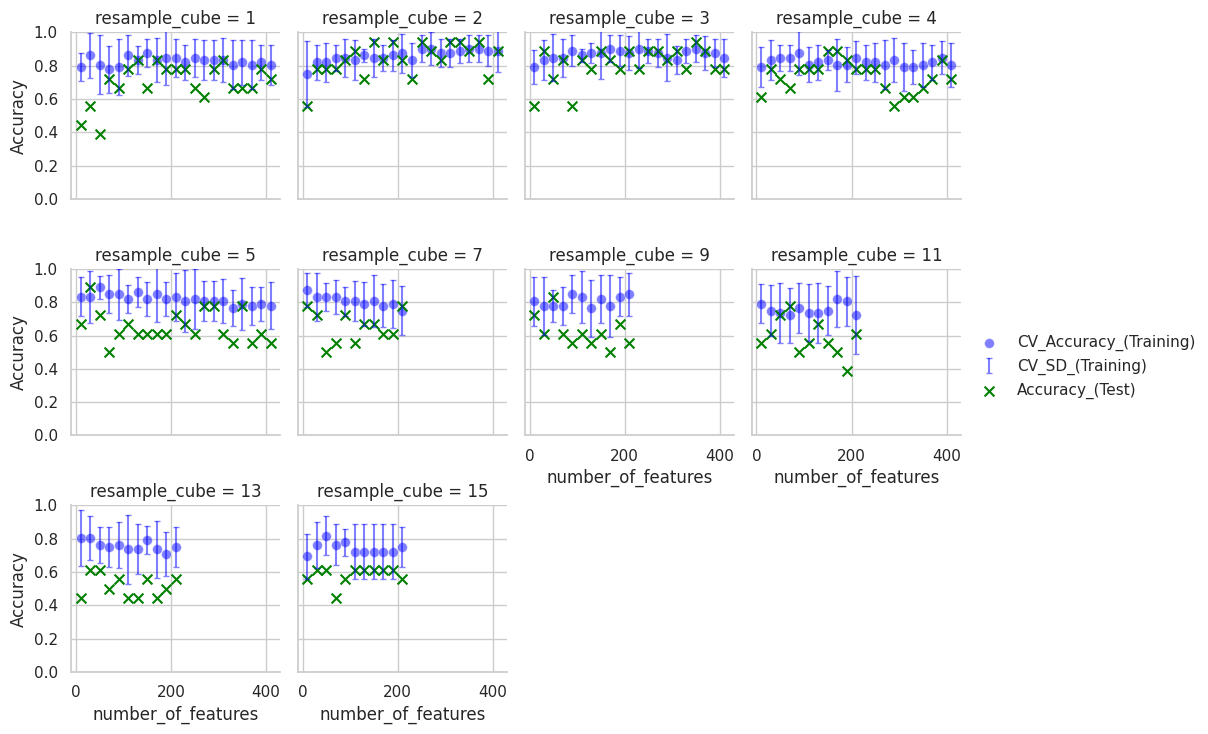

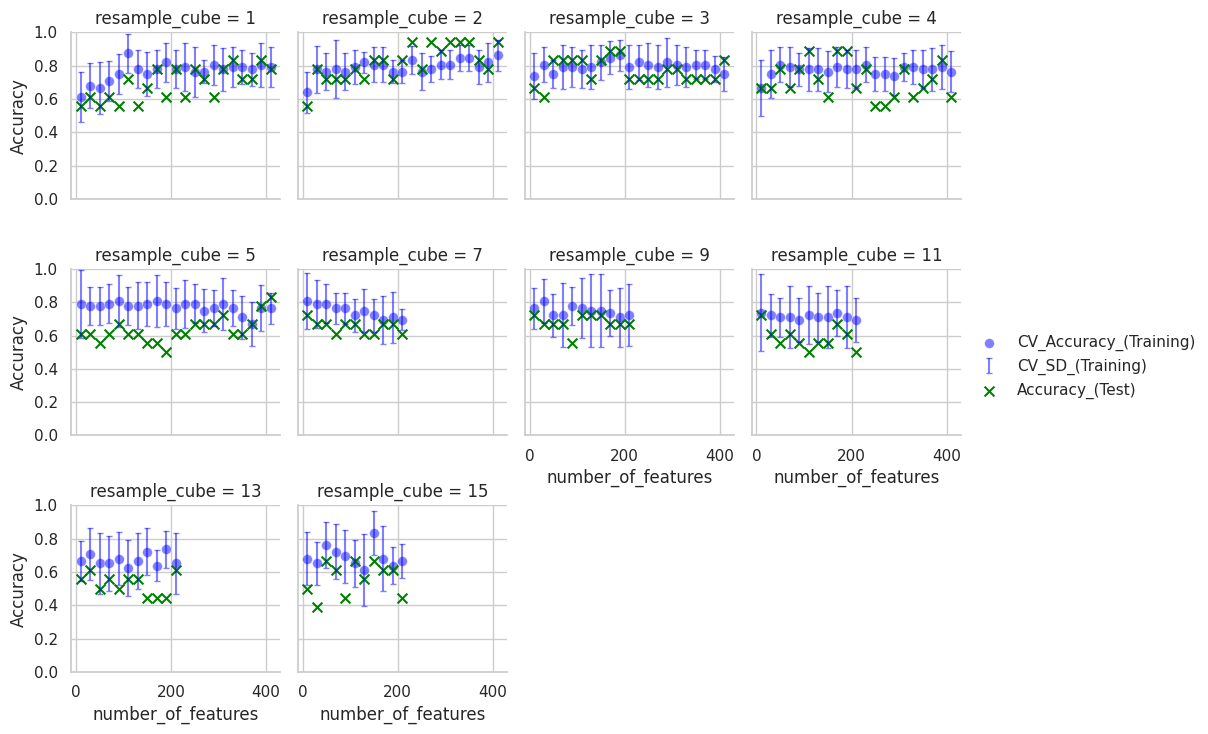

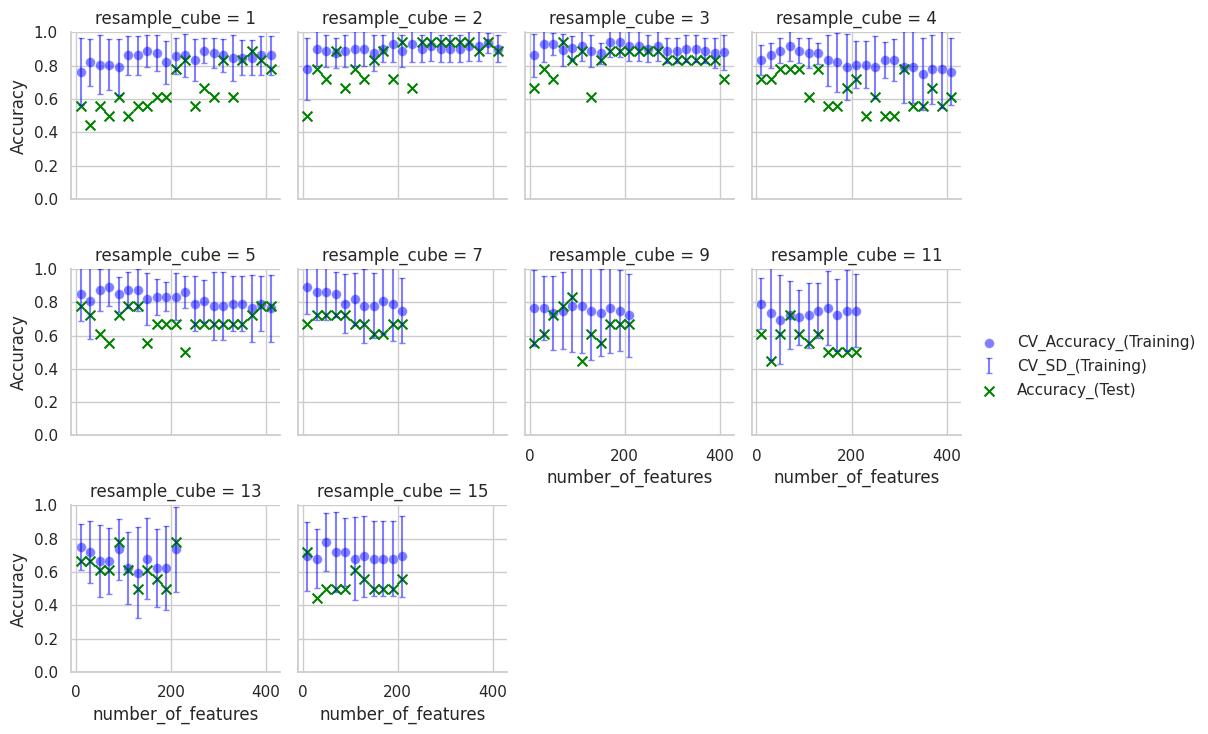

In [88]:
create_plot(col_var="resample_cube", x_var="number_of_features", 
            x_label="number_of_features", datasets=[df_tpot, df_pycaret, df_h2o])


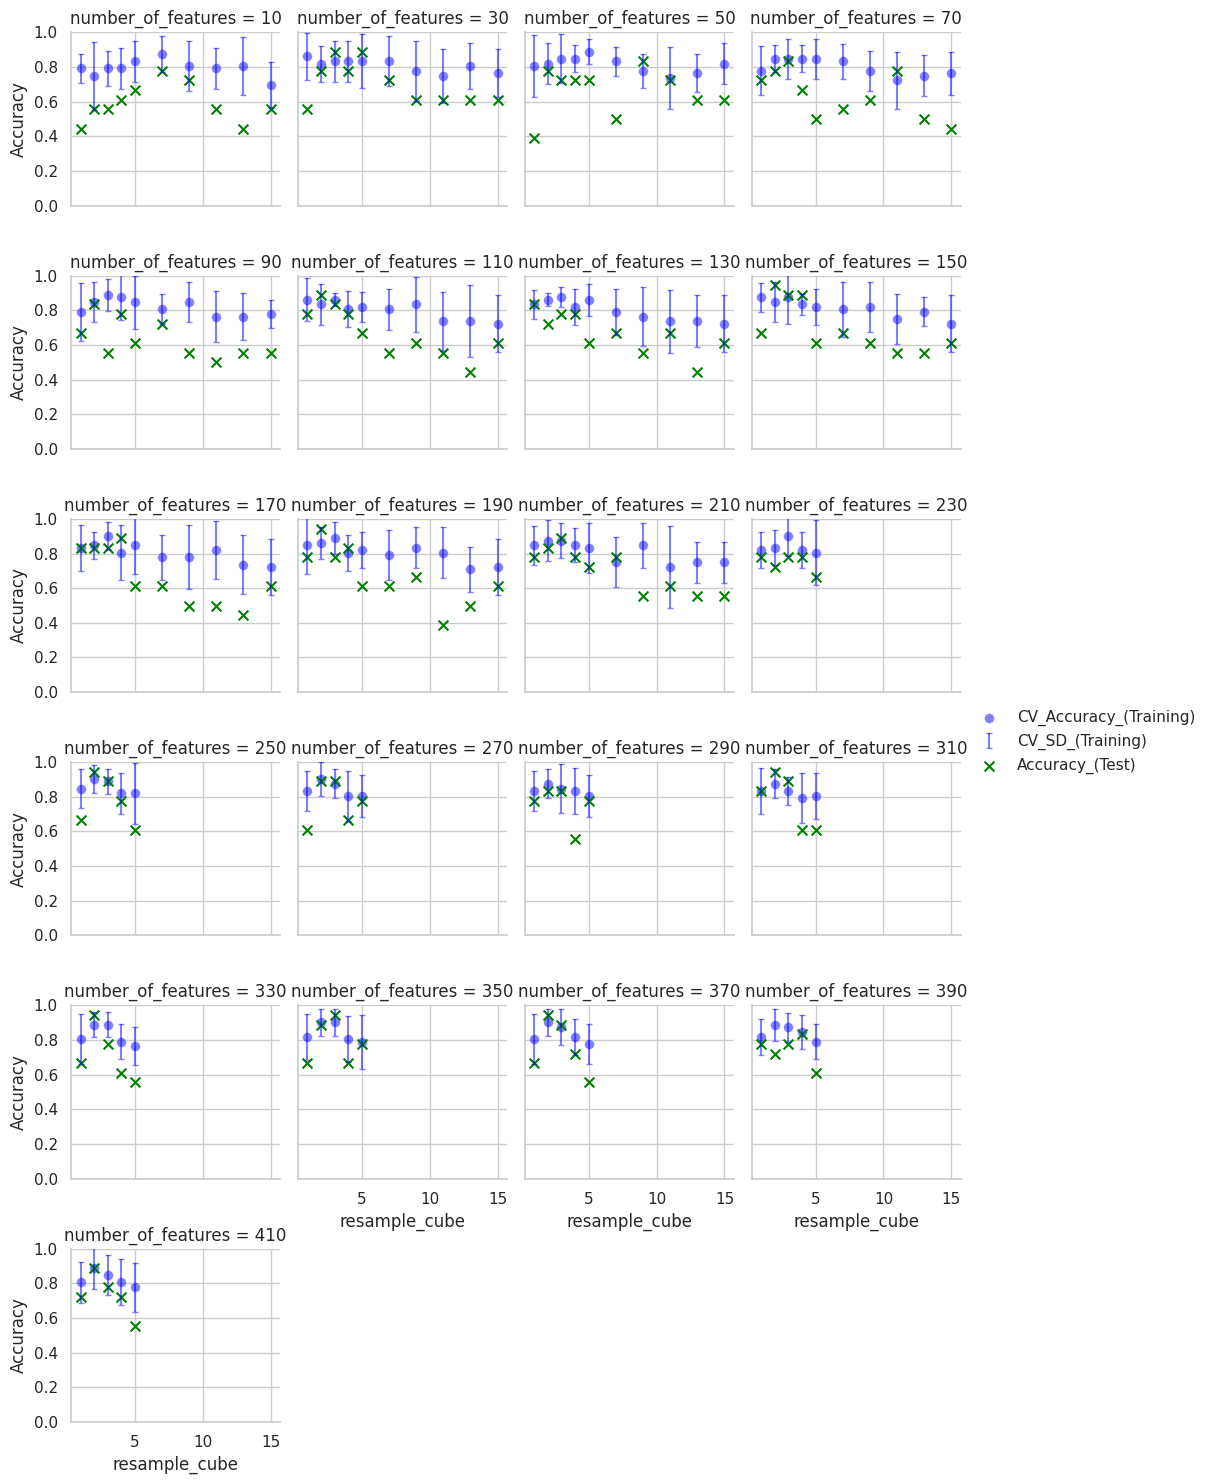

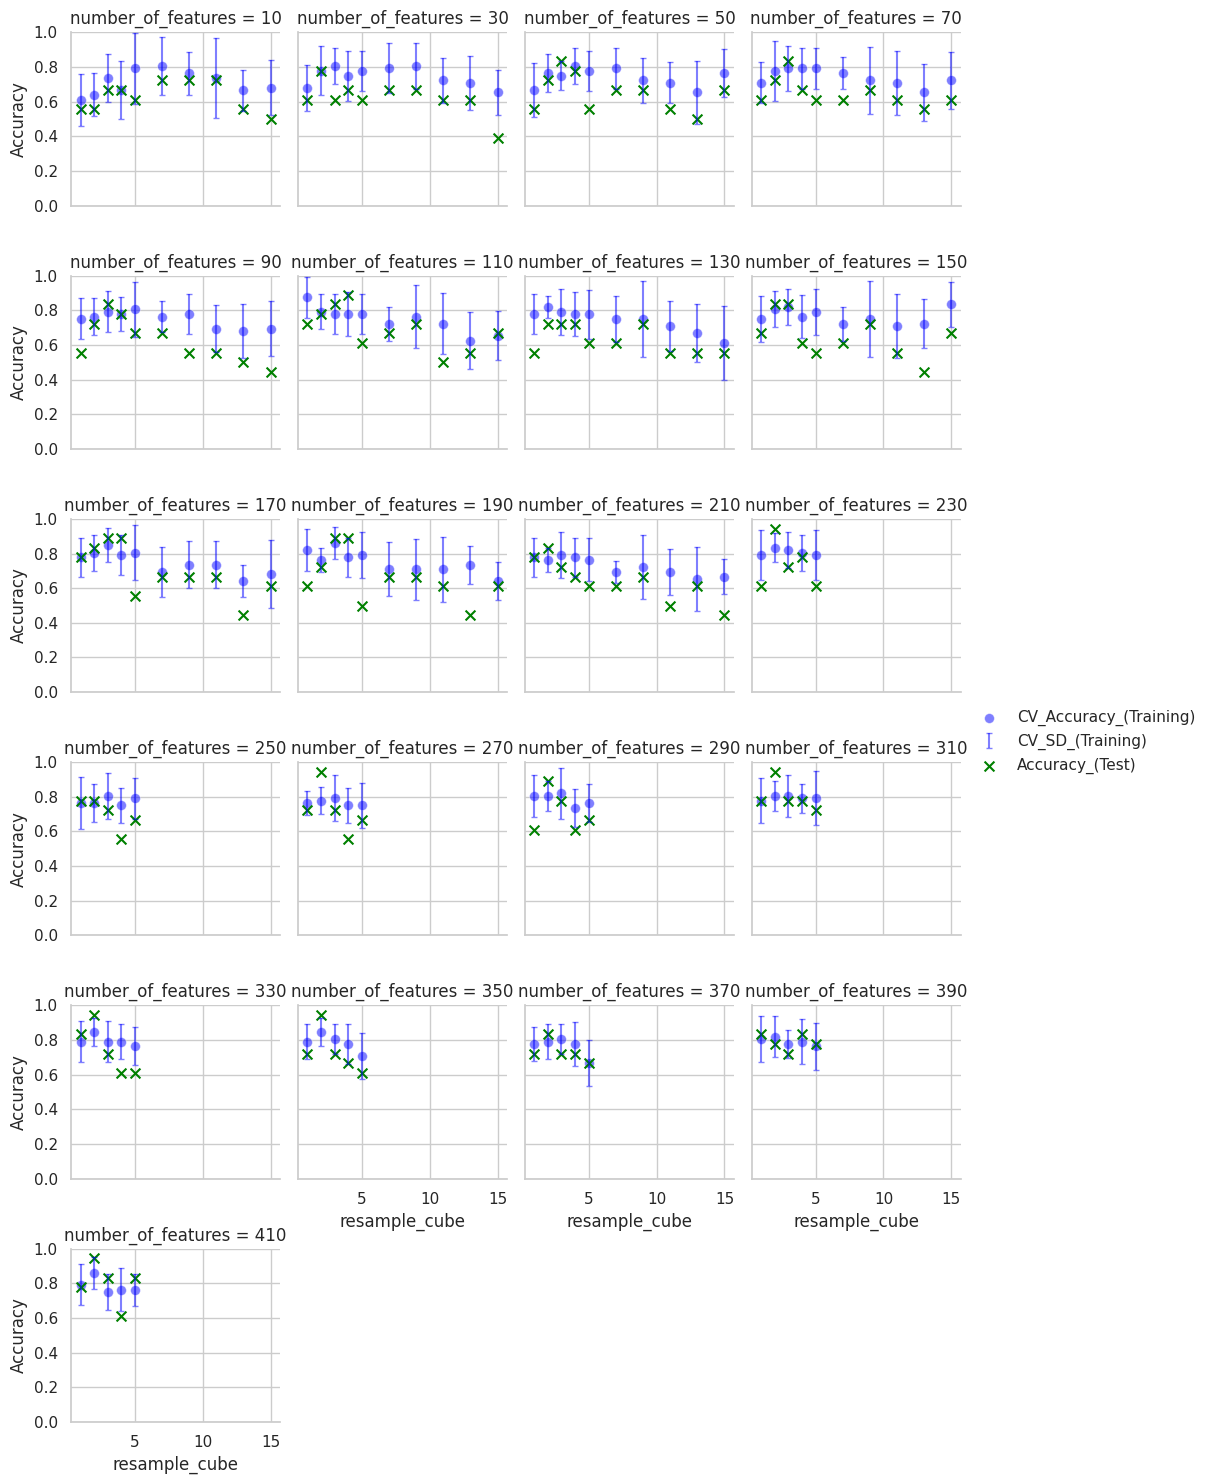

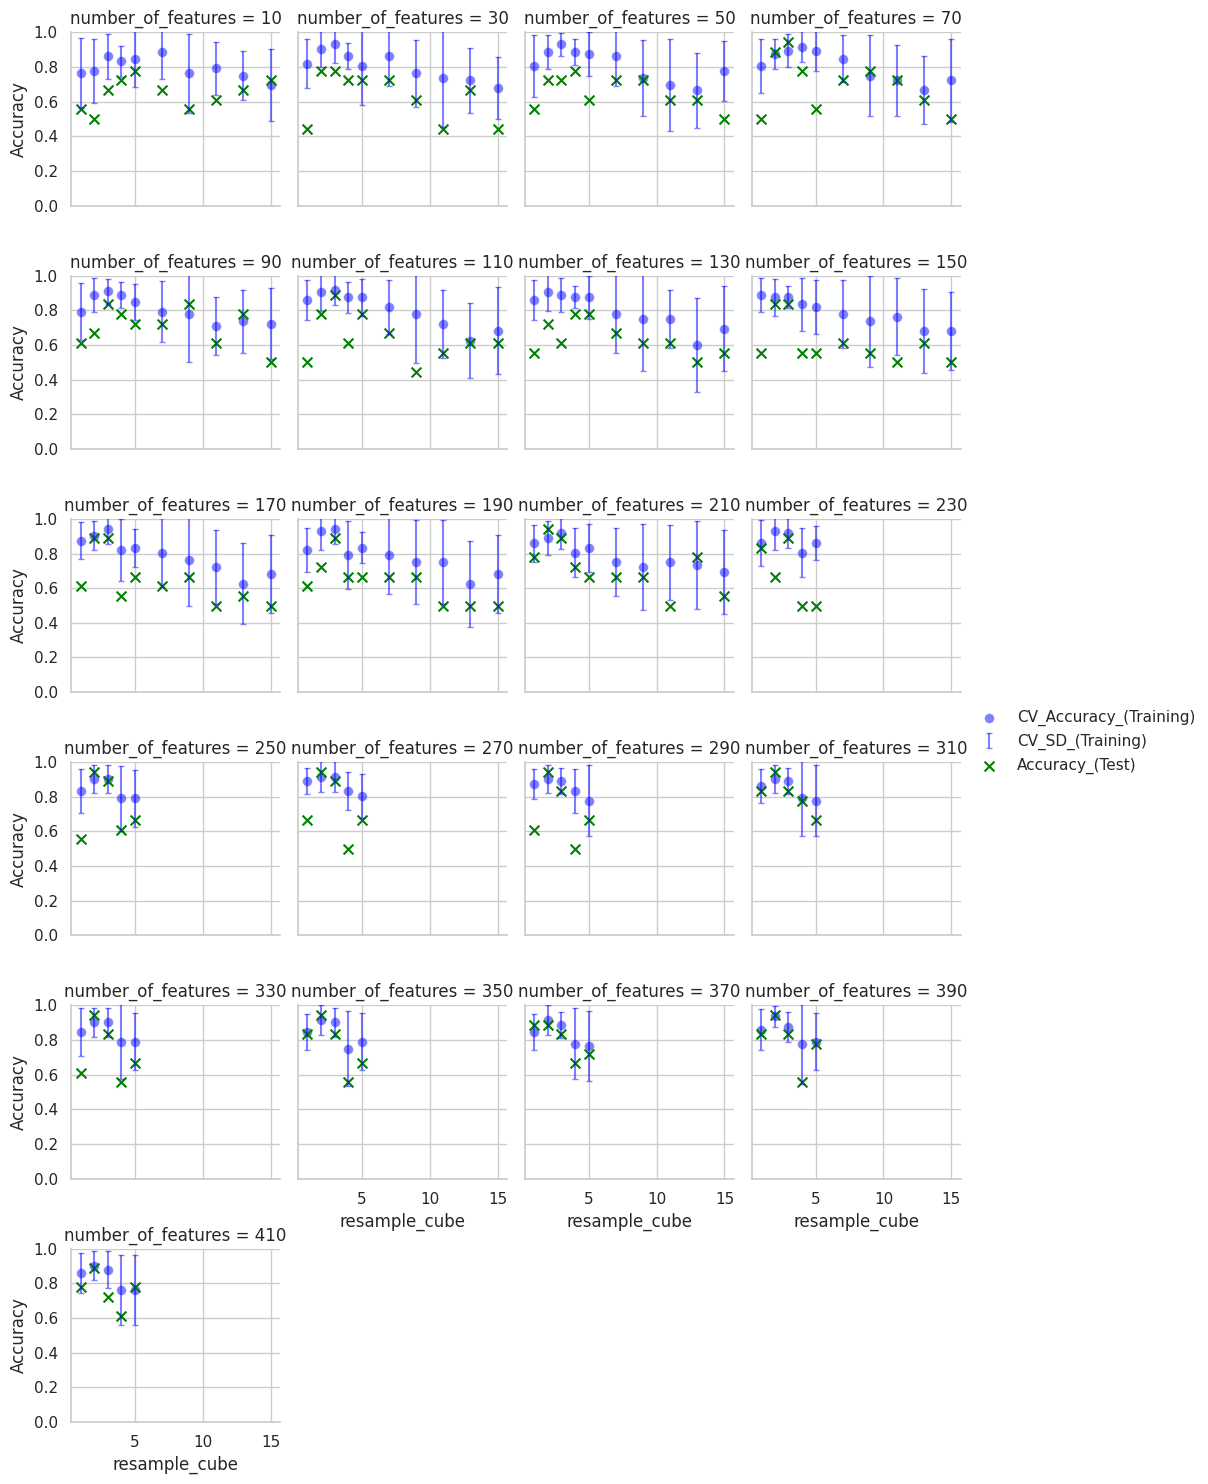

In [89]:
create_plot(col_var="number_of_features", x_var="resample_cube", 
            x_label="resample_cube", datasets=[df_tpot, df_pycaret, df_h2o])


## 3d best marked and printed

Top 1: number_of_features = 150, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 190, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 250, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 350, resample_cube = 3, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 370, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 8: number_of_features = 30, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 9: number_of_features = 150, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 10: number_of_features = 210, resample_cube = 3, Accuracy_(Test) = 0.8889


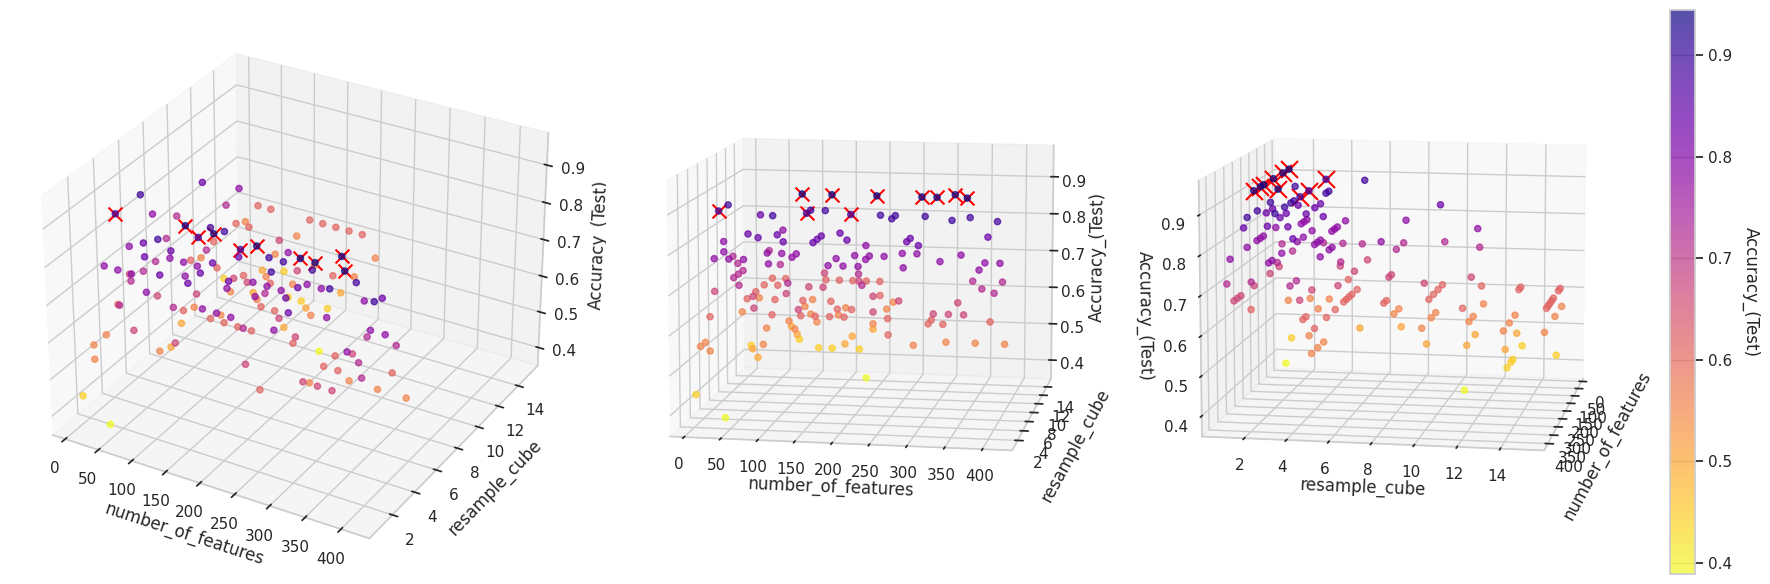

Top 1: number_of_features = 230, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 270, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 350, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 410, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 170, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 8: number_of_features = 190, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 9: number_of_features = 110, resample_cube = 4, Accuracy_(Test) = 0.8889
Top 10: number_of_features = 170, resample_cube = 4, Accuracy_(Test) = 0.8889


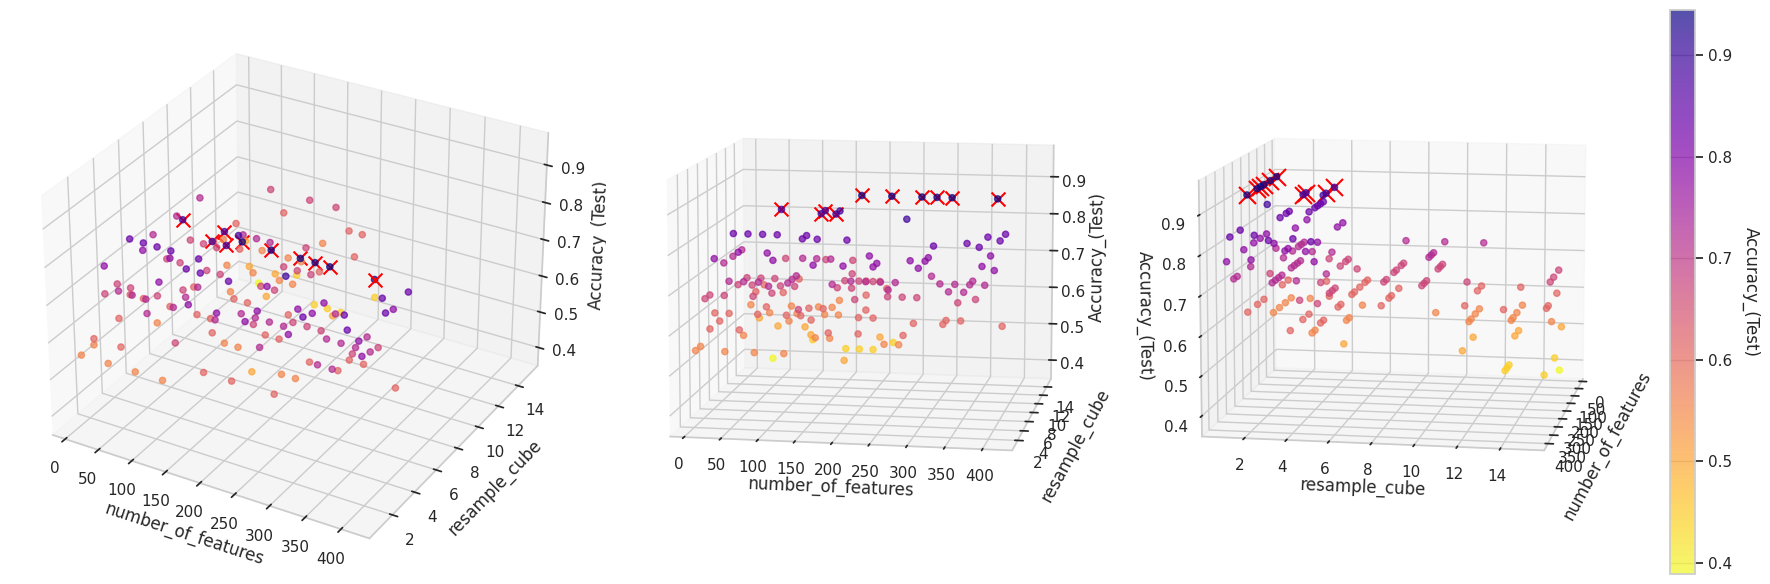

Top 1: number_of_features = 70, resample_cube = 3, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 210, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 250, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 270, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 290, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 8: number_of_features = 350, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 9: number_of_features = 390, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 10: number_of_features = 110, resample_cube = 3, Accuracy_(Test) = 0.8889


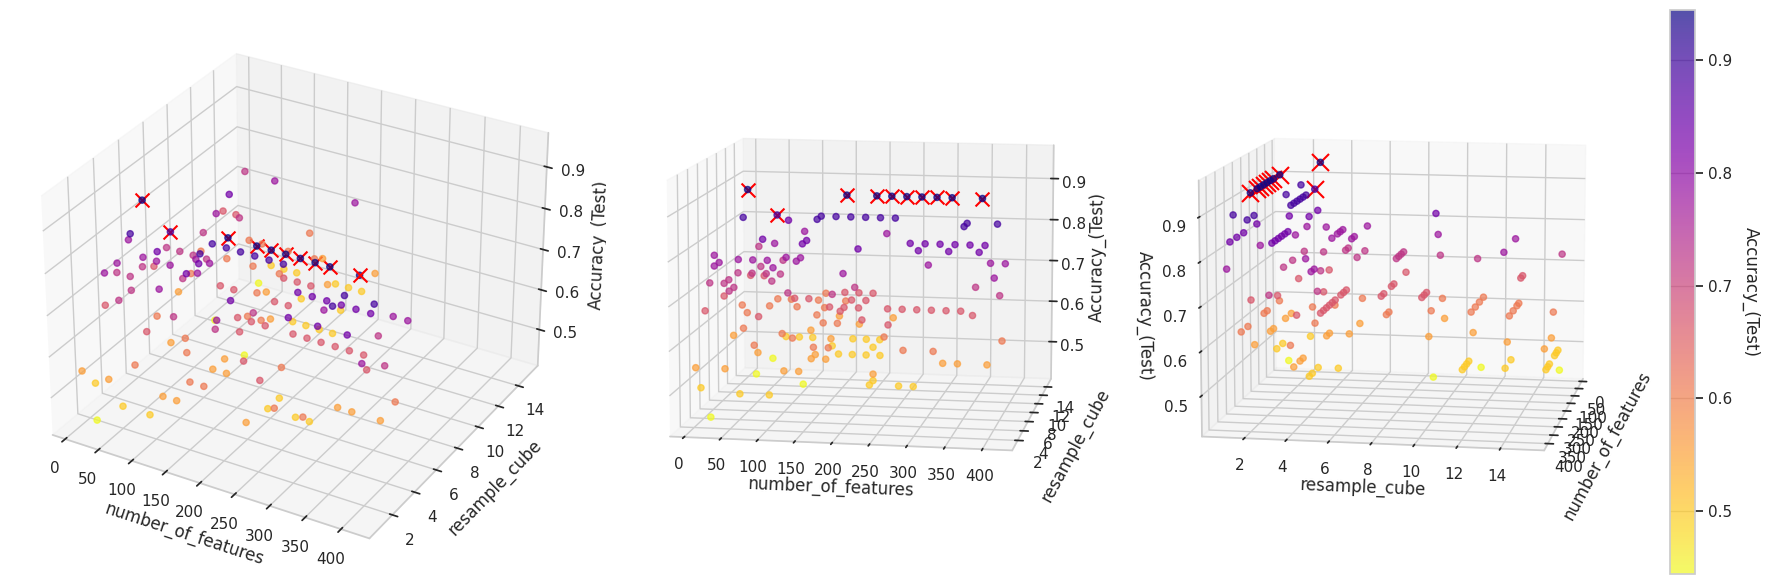

In [90]:
x_best = 10

for df_in_loop in [df_tpot, df_pycaret, df_h2o]:

    # Extract the x, y, and z values from the df DataFrame
    x = df_in_loop['number_of_features']
    y = df_in_loop['resample_cube']
    z = df_in_loop['Accuracy_(Test)']

    # Find the top 3 maximum Accuracy_(Test) values and their corresponding x, y, and z coordinates
    top_3_indexes = z.nlargest(x_best).index
    top_3_coordinates = [(x[i], y[i], z[i]) for i in top_3_indexes]

    # Print the best parameters and the maximum accuracy for the top 3
    for i, (x_value, y_value, z_value) in enumerate(top_3_coordinates, start=1):
        print(f"Top {i}: number_of_features = {x_value}, resample_cube = {y_value}, Accuracy_(Test) = {z_value}")

    # Create the figure
    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1, 4, width_ratios=[2.3, 2, 2, 0.1])

    # First subplot (3D view)
    ax1 = fig.add_subplot(gs[0], projection='3d')
    scatter1 = ax1.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)
    for x_value, y_value, z_value in top_3_coordinates:
        ax1.scatter(x_value, y_value, z_value, c='red', marker='x', s=100)

    # Second subplot (projection along the z-axis)
    ax2 = fig.add_subplot(gs[1], projection='3d')
    scatter2 = ax2.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)
    ax2.view_init(elev=10, azim=-80)  # Change the view angle
    for x_value, y_value, z_value in top_3_coordinates:
        ax2.scatter(x_value, y_value, z_value, c='red', marker='x', s=100)

    # Third subplot (projection along the y-axis)
    ax3 = fig.add_subplot(gs[2], projection='3d')
    scatter3 = ax3.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)
    ax3.view_init(elev=10, azim=10)  # Change the view angle
    for x_value, y_value, z_value in top_3_coordinates:
        ax3.scatter(x_value, y_value, z_value, c='red', marker='x', s=150)

    # Add axis labels
    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('number_of_features')
        ax.set_ylabel('resample_cube')
        ax.set_zlabel('Accuracy_(Test)')

    # Add a colorbar
    cbar_ax = fig.add_subplot(gs[3])
    cbar = fig.colorbar(scatter1, cax=cbar_ax)
    cbar.set_label('Accuracy_(Test)', rotation=270, labelpad=20)

    # Apply tight_layout
    plt.tight_layout()

    plt.show()

# TODO: eventually reverse the axis so that the points are more visible 
# TODO: add a mean surface to the plot

## 3d best marked and printed + surface edges

Top 1: number_of_features = 150, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 190, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 250, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 350, resample_cube = 3, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 370, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 8: number_of_features = 30, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 9: number_of_features = 150, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 10: number_of_features = 210, resample_cube = 3, Accuracy_(Test) = 0.8889


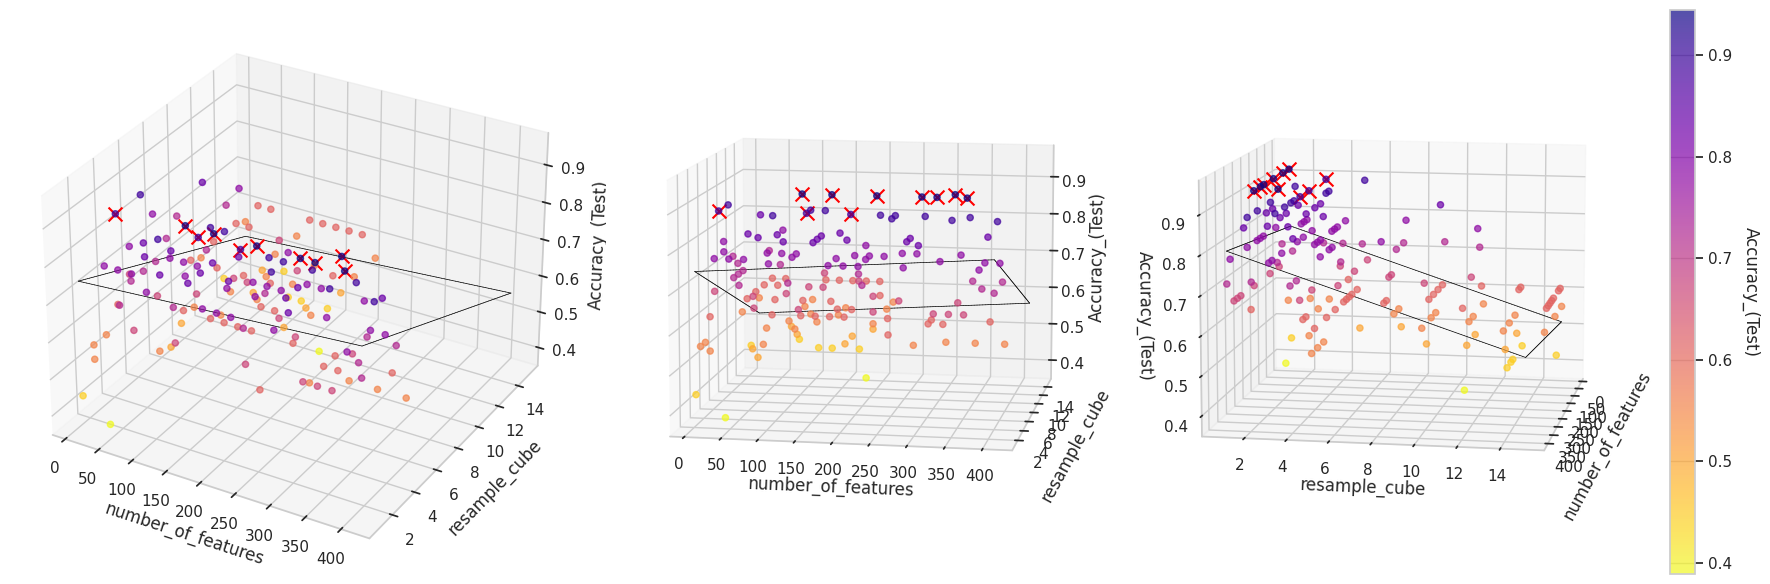

Top 1: number_of_features = 230, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 270, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 350, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 410, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 170, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 8: number_of_features = 190, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 9: number_of_features = 110, resample_cube = 4, Accuracy_(Test) = 0.8889
Top 10: number_of_features = 170, resample_cube = 4, Accuracy_(Test) = 0.8889


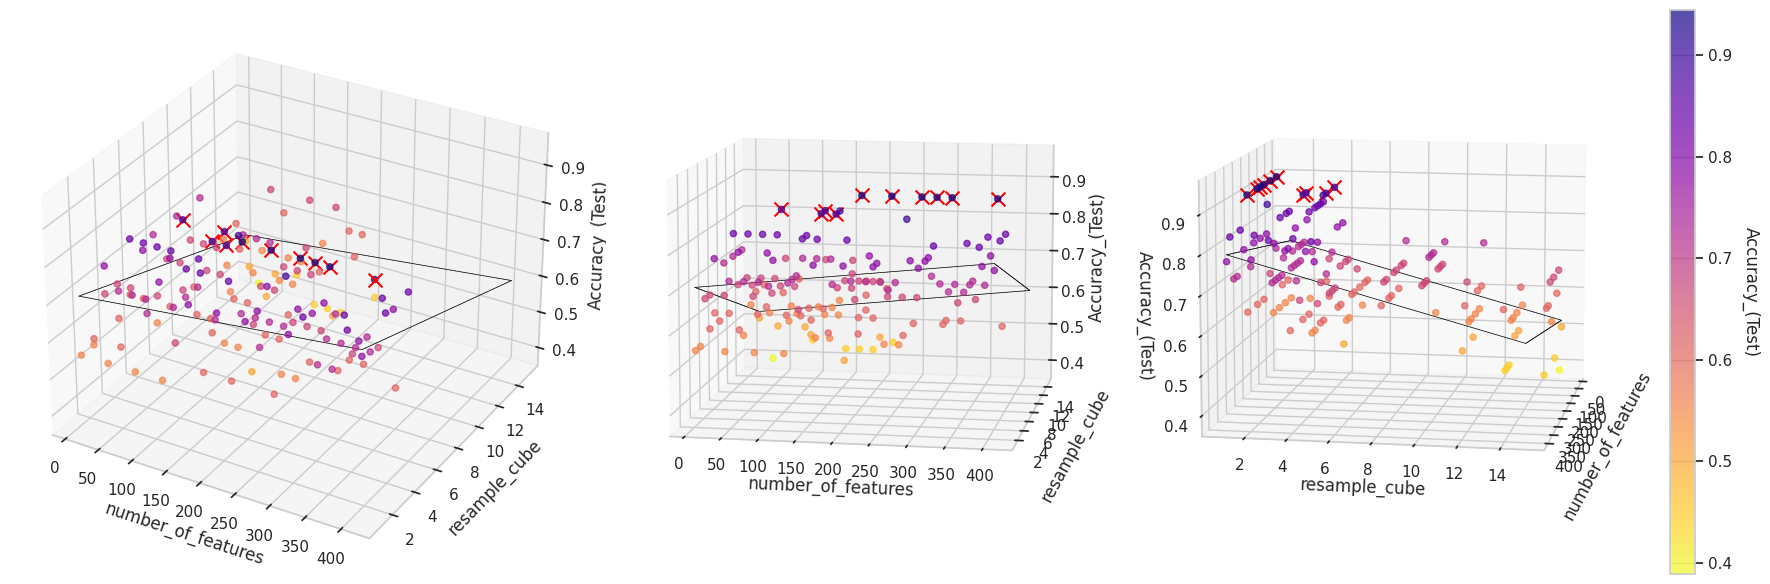

Top 1: number_of_features = 70, resample_cube = 3, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 210, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 250, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 270, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 290, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 8: number_of_features = 350, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 9: number_of_features = 390, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 10: number_of_features = 110, resample_cube = 3, Accuracy_(Test) = 0.8889


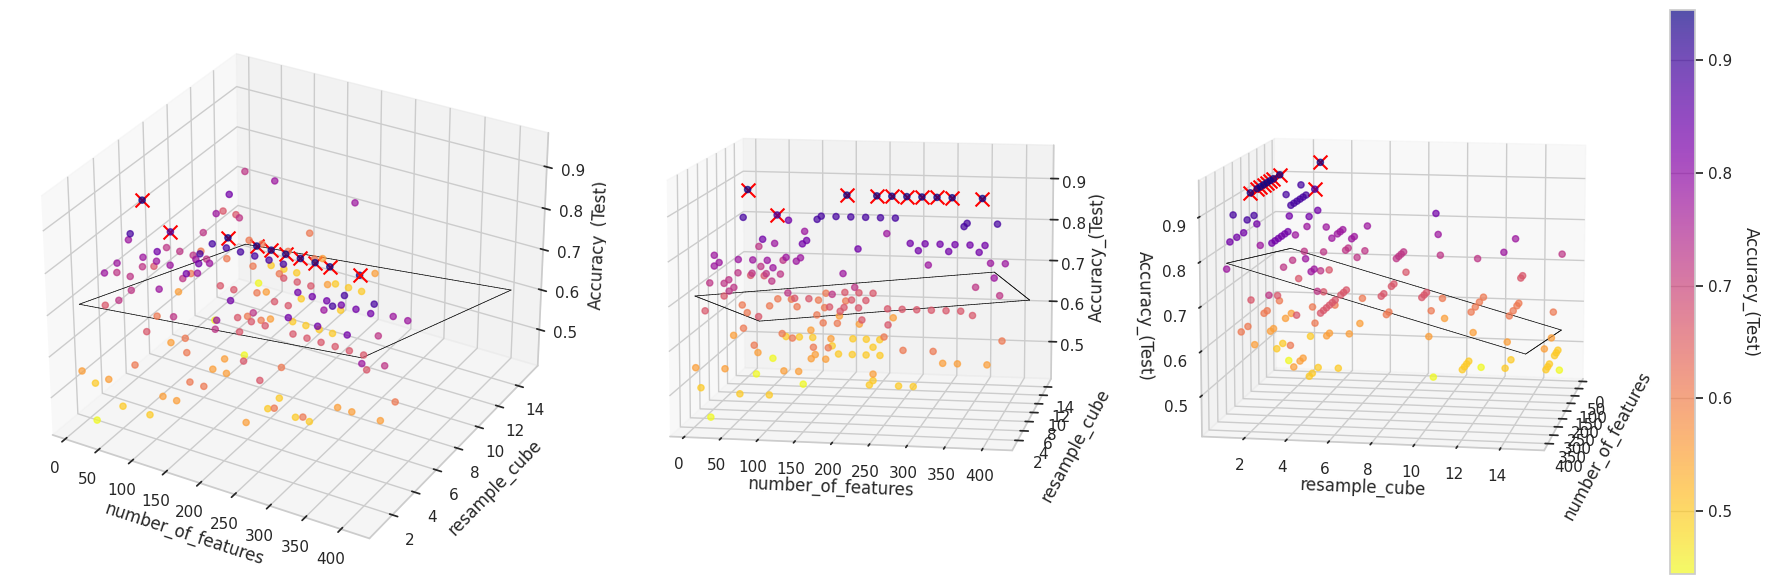

In [91]:
x_best = 10

for df_in_loop in [df_tpot, df_pycaret, df_h2o]:

    # Extract the x, y, and z values from the df DataFrame
    x = df_in_loop['number_of_features']
    y = df_in_loop['resample_cube']
    z = df_in_loop['Accuracy_(Test)']

    # Find the top 3 maximum Accuracy_(Test) values and their corresponding x, y, and z coordinates
    top_3_indexes = z.nlargest(x_best).index
    top_3_coordinates = [(x[i], y[i], z[i]) for i in top_3_indexes]

    # Print the best parameters and the maximum accuracy for the top 3
    for i, (x_value, y_value, z_value) in enumerate(top_3_coordinates, start=1):
        print(f"Top {i}: number_of_features = {x_value}, resample_cube = {y_value}, Accuracy_(Test) = {z_value}")

    # Create the figure
    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1, 4, width_ratios=[2.3, 2, 2, 0.1])

    # Generate the grid for interpolation
    x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))

    # 2D linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(np.column_stack((x, y)), z)
    z_grid = lin_reg.predict(np.column_stack((x_grid.ravel(), y_grid.ravel()))).reshape(x_grid.shape)

    for index, view_angle in enumerate([(30, -60), (10, -80), (10, 10)]):

        # Create a 3D scatter plot
        ax = fig.add_subplot(gs[index], projection='3d')
        scatter = ax.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)

        # Plot the top 3 accuracy values
        for x_value, y_value, z_value in top_3_coordinates:
            ax.scatter(x_value, y_value, z_value, c='red', marker='x', linewidth=1.5, s=100)

        # Plot the outer edges of the surface in black
        # Horizontal lines (front and back)
        for i in [0, -1]:
            for j in range(z_grid.shape[1] - 1):
                ax.plot(x_grid[i, j:j+2], y_grid[i, j:j+2], z_grid[i, j:j+2], color='black', linewidth=0.5)

        # Vertical lines (left and right)
        for i in [0, -1]:
            for j in range(z_grid.shape[0] - 1):
                ax.plot(x_grid[j:j+2, i], y_grid[j:j+2, i], z_grid[j:j+2, i], color='black', linewidth=0.5)

        # Set the view angle
        ax.view_init(*view_angle)

        # Add axis labels
        ax.set_xlabel('number_of_features')
        ax.set_ylabel('resample_cube')
        ax.set_zlabel('Accuracy_(Test)')

    # Add a colorbar
    cbar_ax = fig.add_subplot(gs[3])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label('Accuracy_(Test)', rotation=270, labelpad=20)

    # Apply tight_layout
    plt.tight_layout()

    plt.show()


## Heatmap

/tmp/ipykernel_3127661/2624597776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_loop['Accuracy_(Test)_percentage'] = df_in_loop['Accuracy_(Test)'] * 100


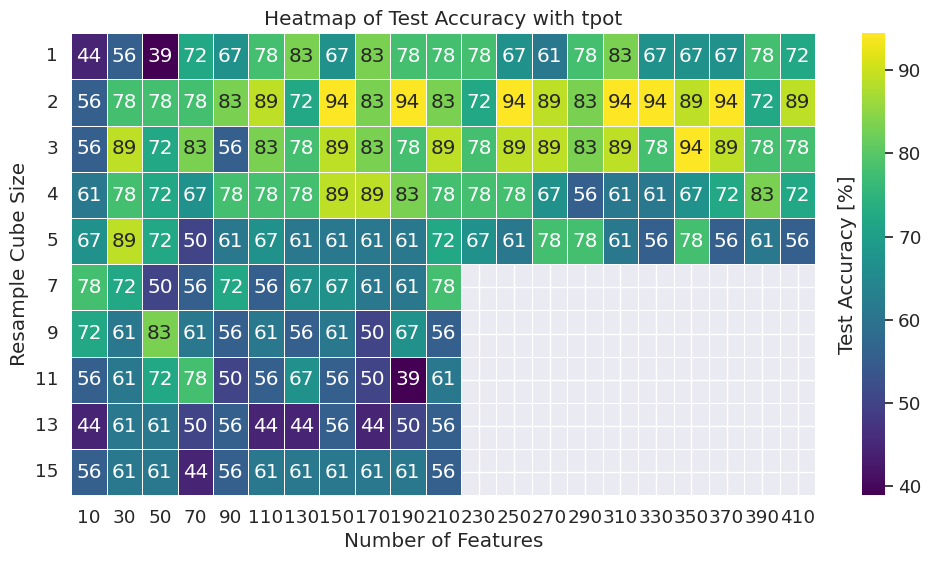

/tmp/ipykernel_3127661/2624597776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_loop['Accuracy_(Test)_percentage'] = df_in_loop['Accuracy_(Test)'] * 100


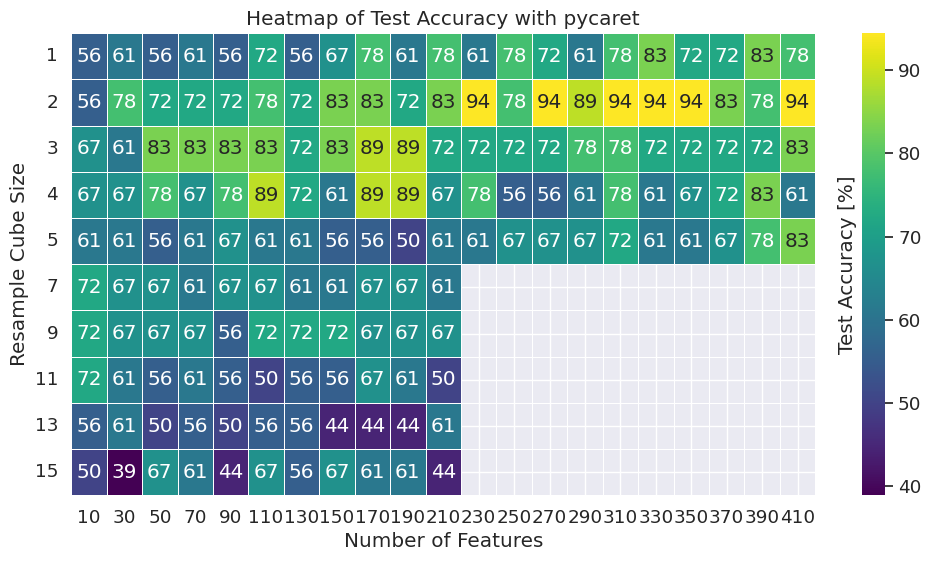

/tmp/ipykernel_3127661/2624597776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_loop['Accuracy_(Test)_percentage'] = df_in_loop['Accuracy_(Test)'] * 100


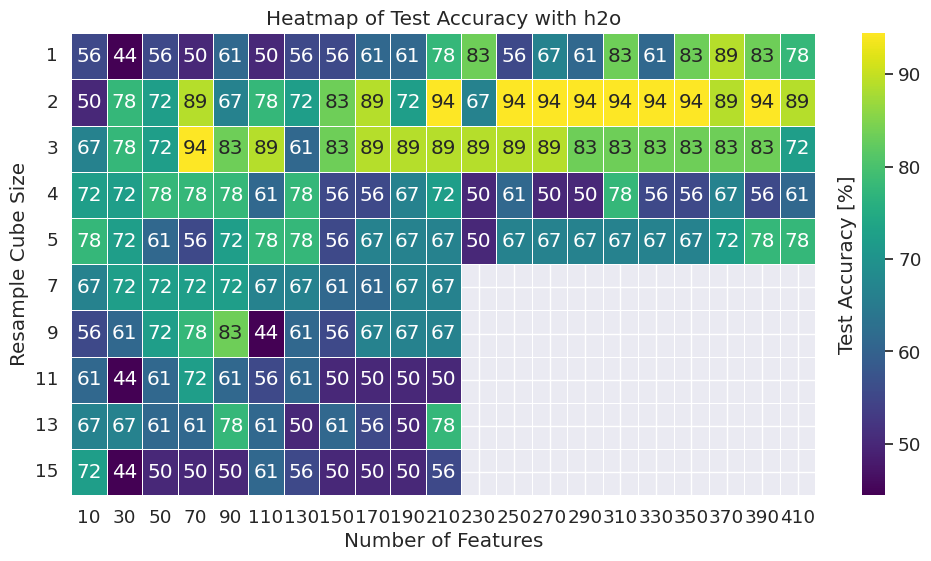

In [92]:
for i, df_in_loop in enumerate([df_tpot, df_pycaret, df_h2o]):

    # create a new column where the Accuracy_(Test) are in percentage
    df_in_loop['Accuracy_(Test)_percentage'] = df_in_loop['Accuracy_(Test)'] * 100

    # Pivot the dataframe
    pivot_df = df_in_loop.pivot(
        index='resample_cube', columns='number_of_features', values='Accuracy_(Test)_percentage'
    )

    # Create the heatmap
    plt.figure(figsize=(12, 6))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.0f', linewidths=.5)
    ax.set_title(f'Heatmap of Test Accuracy with {tool_list[i]}')

    # Set labels
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Resample Cube Size')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Test Accuracy [%]', rotation=90, labelpad=-60)

    # Show the plot
    plt.show()

## comparison of autpML tools for best resample cubes

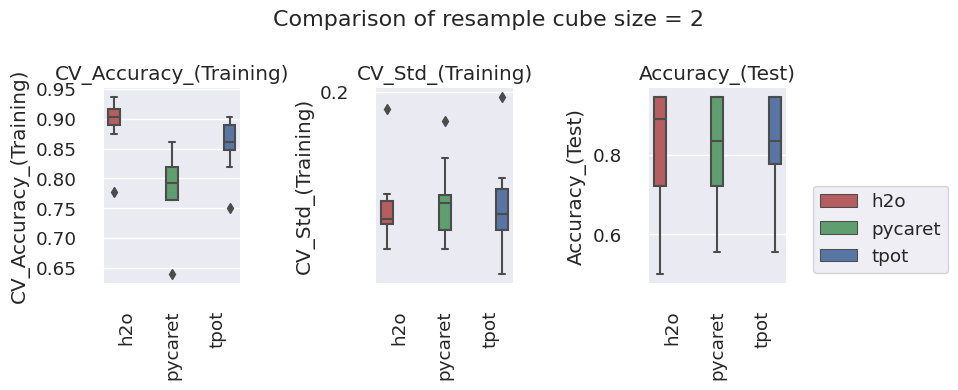

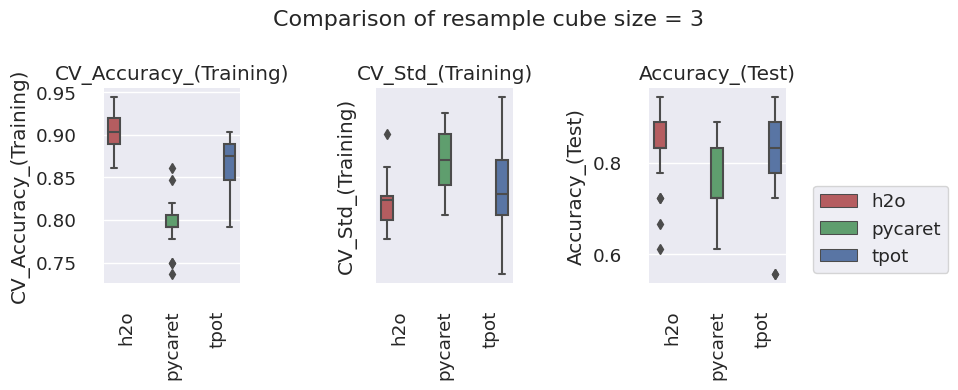

In [93]:
for c in [2, 3]:
    df1 = df_no_param_dup.loc[df_no_param_dup['resample_cube'] == c, :]

    plot_columns = ["CV_Accuracy_(Training)", "CV_Std_(Training)", "Accuracy_(Test)"]

    num_columns = len(plot_columns)
    num_rows = 1
    num_cols = int(np.ceil(num_columns / num_rows))

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 4))

    # Flatten the axes array to make it easier to loop through
    flat_axes = axes.flatten()

    for i, col in enumerate(plot_columns):
        sns.boxplot(data=df1, y=col, x="tool",
                    hue="tool", palette=["r", "g", "b"],
                    ax=flat_axes[i])
        flat_axes[i].set_title(col)
        flat_axes[i].yaxis.grid(True)
        # flat_axes[i].set_ylim(0, 1)
        sns.despine(offset=10, trim=True)
        
        # Remove the legend for all subplots except the last one
        if i != num_columns - 1:
            flat_axes[i].get_legend().remove()
        else:
            # Place the legend outside the last subplot on the right side
            flat_axes[i].legend(bbox_to_anchor=(1.2, 0.5), loc='upper left', borderaxespad=0.)

        flat_axes[i].set_xlabel("")
        flat_axes[i].tick_params(axis='x', rotation=90)


    # Remove any unused axes
    for j in range(i+1, num_rows * num_cols):
        flat_axes[j].set_visible(False)

    fig.suptitle(f"Comparison of resample cube size = {c}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(wspace=1)
    plt.show()  

## 3d smooth surface plot (probably not useful)

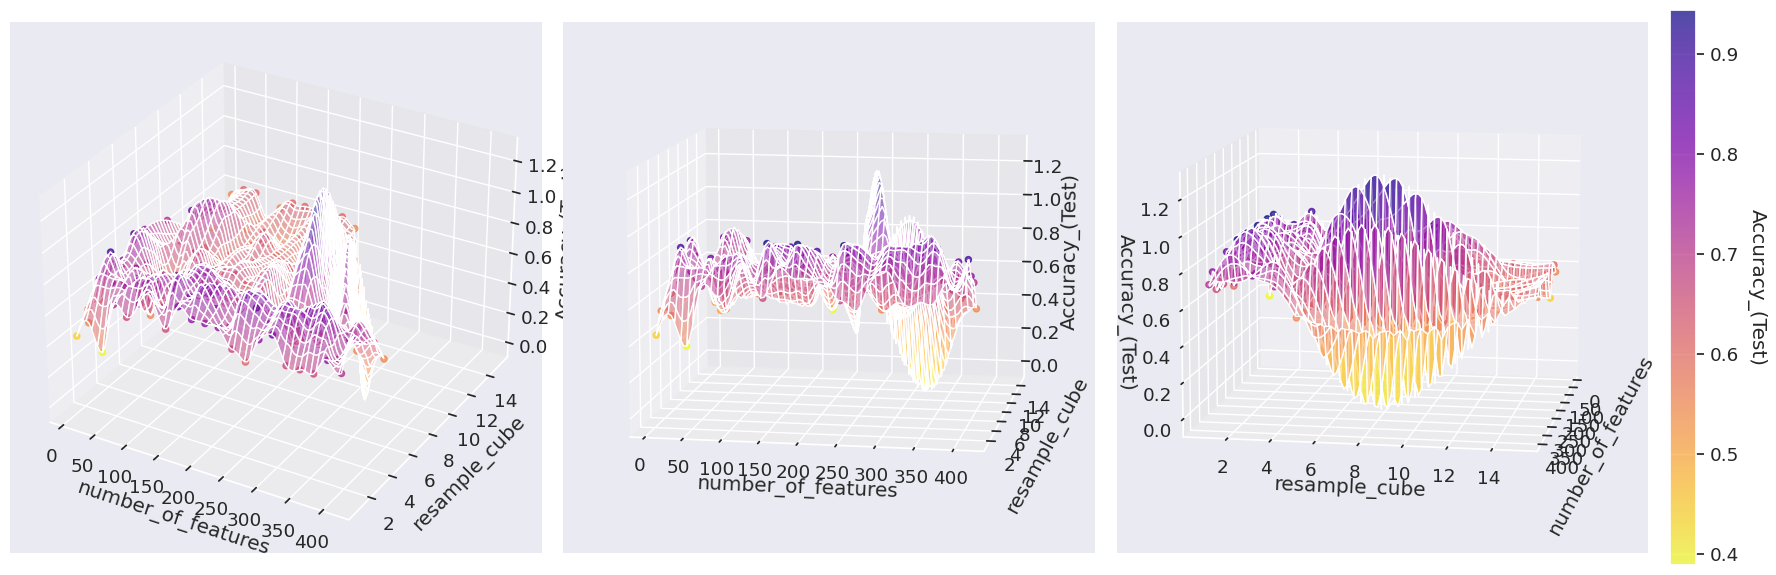

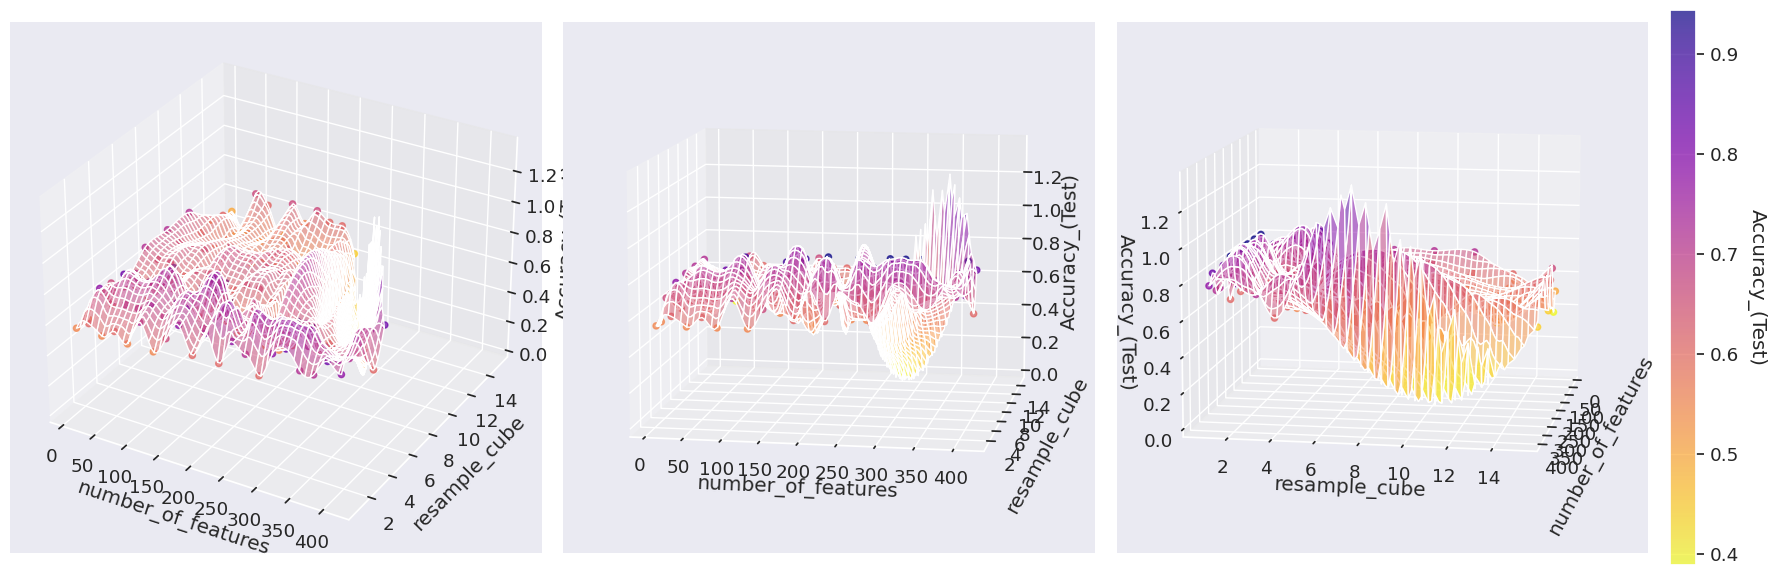

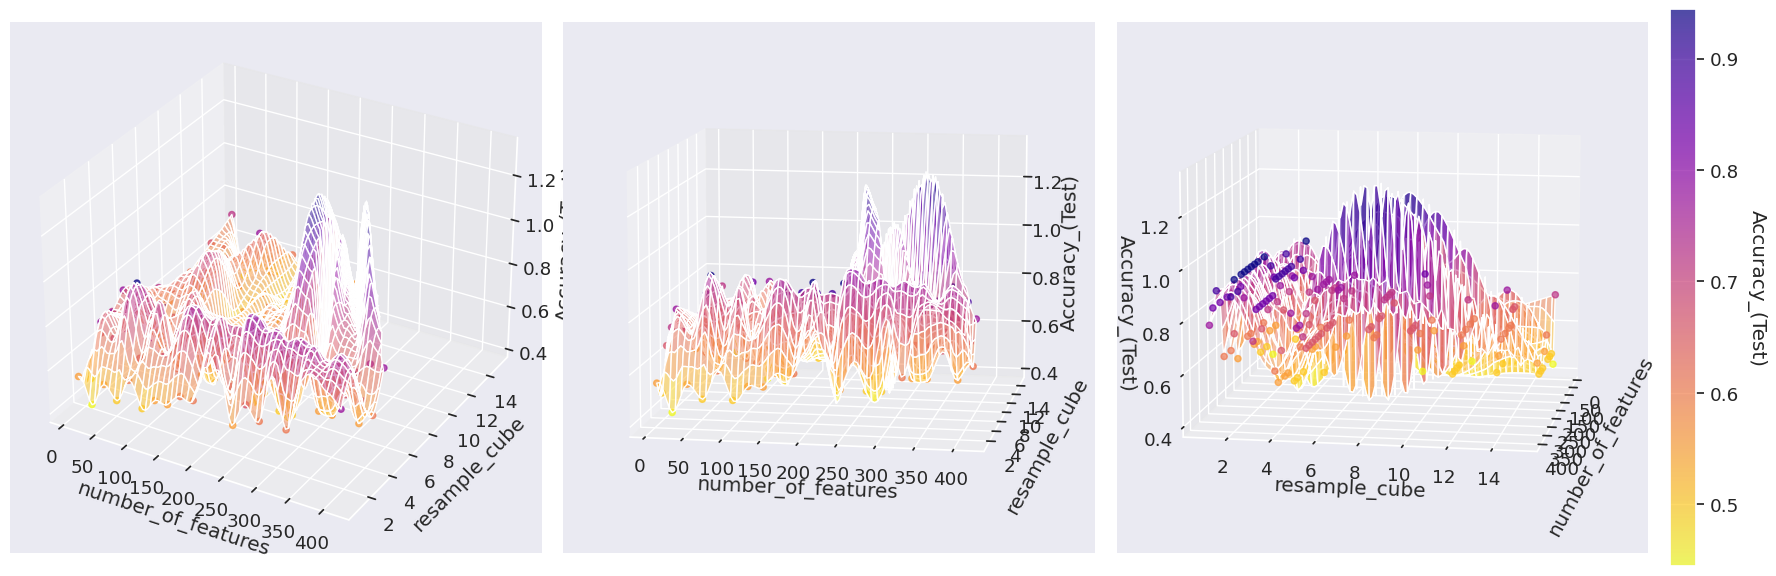

In [94]:
for df in [df_tpot, df_pycaret, df_h2o]:

    # Extract the x, y, and z values from the df DataFrame
    x = df['number_of_features']
    y = df['resample_cube']
    z = df['Accuracy_(Test)']

    # Create the figure
    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1, 4, width_ratios=[2, 2, 2, 0.1])

    # Generate the grid for interpolation
    x_grid, y_grid = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

    # Interpolate the z values on the grid
    z_grid = griddata((x, y), z, (x_grid, y_grid), method='cubic')

    for index, view_angle in enumerate([(30, -60), (10, -80), (10, 10)]):

        # Create a 3D scatter plot
        ax = fig.add_subplot(gs[index], projection='3d')
        scatter = ax.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)

        # Plot the smooth surface
        ax.plot_surface(x_grid, y_grid, z_grid, cmap='plasma_r', alpha=0.5)

        # Set the view angle
        ax.view_init(*view_angle)

        # Add axis labels
        ax.set_xlabel('number_of_features')
        ax.set_ylabel('resample_cube')
        ax.set_zlabel('Accuracy_(Test)')

    # Add a colorbar
    cbar_ax = fig.add_subplot(gs[3])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label('Accuracy_(Test)', rotation=270, labelpad=20)

    # Apply tight_layout
    plt.tight_layout()

    plt.show()
